In [ ]:
original dataset https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing

# Import

In [1]:
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import confusion_matrix,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

import sklearn.preprocessing as preproc
from imblearn.over_sampling import SMOTE

import warnings 
warnings.filterwarnings('ignore')

sns.set()

# Helpers

Helper functions

In [2]:
def convert_col_to_proper_int(df_col):
    col_type = df_col.dtype
    if ((str(col_type)[:3] == 'int') | (str(col_type)[:4] == 'uint')): 
        c_min = df_col.min()
        c_max = df_col.max()
        if c_min < 0:
            if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                df_col = df_col.astype(np.int8)
            elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                df_col = df_col.astype(np.int16)
            elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                df_col = df_col.astype(np.int32)
            elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                df_col = df_col.astype(np.int64)
        else:
            if c_max <= np.iinfo(np.uint8).max:
                df_col = df_col.astype(np.uint8)
            elif c_max <= np.iinfo(np.uint16).max:
                df_col = df_col.astype(np.uint16)
            elif c_max <= np.iinfo(np.uint32).max:
                df_col = df_col.astype(np.uint32)
            elif c_max <= np.iinfo(np.uint64).max:
                df_col = df_col.astype(np.uint64)
            
    return df_col

def convert_col_to_proper_float(df_col):
    col_type = df_col.dtype
    if str(col_type)[:5] == 'float':
        unique_count = len(np.unique(df_col))
        df_col_temp = df_col.astype(np.float32)
        if len(np.unique(df_col_temp)) == unique_count:
            df_col = df_col_temp
            c_min = df_col.min()
            c_max = df_col.max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_col_temp = df_col.astype(np.float16)
                if len(np.unique(df_col_temp)) == unique_count:
                    df_col = df_col_temp
    return df_col

def float_to_int(df_):
    for col in df_.columns:
        col_type = df_[col].dtype
        if str(col_type)[:5] == 'float':
            if (df_[col] % 1 == 0).all():
                df_[col] = convert_col_to_proper_int(df_[col].astype(np.int64))
    
    return df_

def float_reduced(df_):
    for col in df_.columns:
        col_type = df_[col].dtype
        if str(col_type)[:5] == 'float':
            df_[col] = convert_col_to_proper_float(df_[col])
    return df_

def int_reduced(df_):
    for col in df_.columns:
        df_[col] = convert_col_to_proper_int(df_[col])        
    return df_

def df_reduce_mem_usage(df_, verbose = True):
    start_mem = df_.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in df_.columns:
        col_type = df_[col].dtype

        if ((col_type != object) & (col_type != '<M8[ns]') & (col_type.name != 'category')):#
            c_min = df_[col].min()
            c_max = df_[col].max()
            if str(col_type)[:3] == 'int':
                df_[col] = convert_col_to_proper_int(df_[col])
            else:
                if (df_[col] % 1 == 0).all():
                    df_[col] = convert_col_to_proper_int(df_[col].astype(np.int64))
                else:
                    df_[col] = convert_col_to_proper_float(df_[col])
        else: 
            try:
                df_[col] = df_[col].astype(np.float64)
                if (df_[col] % 1 == 0).all():
                    df_[col] = convert_col_to_proper_int(df_[col].astype(np.int64))
                else:
                    df_[col] = convert_col_to_proper_float(df_[col])
            except:
                df_[col] = df_[col].astype('category')

    end_mem = df_.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df_

def df_feats_summary(df_, cols_to_exclude, verbose = True ):
    feats_to_exclude = [f for f in df_.columns if f in cols_to_exclude]

    cat_cols  = [col for col in df_.columns if df_[col].dtype == 'object']
    cat_cols += [col for col in df_.columns if not pd.api.types.is_numeric_dtype(df_[col].dtype)]
    cat_cols  = list(set(cat_cols).difference(feats_to_exclude))

    num_cols = [col for col in df_.columns if pd.api.types.is_numeric_dtype(df_[col].dtype)]
    num_cols  = list(set(num_cols).difference(feats_to_exclude))
    if verbose:
        print('''Columns summary (total {}) : 
        1. Categorical: {}
        2. Numerical: {}
        3. Excluded: {}'''.format(len(df_.columns),len(cat_cols),len(num_cols),len(feats_to_exclude)))
    return feats_to_exclude,cat_cols,num_cols

def df_missing_report(df_):
    count_missing = df_.isnull().sum().values
    ratio_missing = count_missing / df_.shape[0]
    
    return pd.DataFrame(data = {'count_missing': count_missing, 
                                'ratio_missing': ratio_missing},
                        index = df_.columns.values)

def df_impute(df_, strategy = 'median',value = None):
  
    for col in df_.columns:
        if (col in df_._get_numeric_data().columns):
            df_[col] = df_[col].replace([np.inf, -np.inf], np.nan)        
        if strategy == 'median':
            val = df_[col].median()
        if strategy == 'mean':
            val = df_[col].mean()
        if strategy == 'mode':
            val = df_[col].mode()
        if strategy == 'value':
            val = value
            
        if df_[col].dtype.name == 'category':
            df_[col] = df_[col].cat.add_categories(val).fillna(val)
        else:
            df_[col] = df_[col].fillna(val)
    return df_

def draw_plots(df,keys_to_draw:list,graph_type:str,n_cols:int = 3,xlabel:str = None,ylabel:str = None,target_split=False):
    n_rows = math.ceil(len(keys_to_draw)/n_cols)
    for i in range(n_rows):
        fig, ax = plt.subplots(nrows=1, 
                             ncols=n_cols, 
                             figsize=(16, 4))
 
        for j,col in enumerate(ax):  
            if (n_cols*i+j)<(len(keys_to_draw)):
                if graph_type == 'hist':
                    if target_split:
                        sns.distplot(df[df['TARGET']==0][keys_to_draw[n_cols*i+j]], ax=col,color = 'red',label = "Target is 0")
                        sns.distplot(df[df['TARGET']==1][keys_to_draw[n_cols*i+j]], ax=col,color = 'green',label = "Target is 1")
                    else:
                        sns.distplot(df[keys_to_draw[n_cols*i+j]], ax=col)
                    col.legend()
                    col.set_xlabel(xlabel)
                    col.set_ylabel(ylabel)
                elif graph_type == 'boxplot':
                    if target_split:
                        sns.boxplot(x="TARGET", y=keys_to_draw[n_cols*i+j], data=df,ax=col)
                    else:
                        sns.boxplot(x=df[keys_to_draw[n_cols*i+j]], ax=col)
                elif graph_type == 'countplot':
                    if target_split:
                        sns.countplot(y=keys_to_draw[n_cols*i+j],hue='TARGET', data=df,ax=col)
                    else:
                        sns.countplot(x=keys_to_draw[n_cols*i+j], data=df,ax=col)
                col.set_title(keys_to_draw[n_cols*i+j])
        fig.tight_layout()
        plt.show()

# Load data

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# rename columns and transform TARGET column from yes/no to 1/0
train_df.rename(index=str, columns={"subscription": "TARGET","id":"ID"},inplace=True)
train_df['TARGET'].replace({'yes': 1, 'no': 0},inplace=True);

test_df.rename(index=str, columns={"id":"ID"},inplace=True)

print('Dataframes shapes: \nTrain:{}\nTest{}'.format(train_df.shape,test_df.shape))

Dataframes shapes: 
Train:(18647, 18)
Test(19035, 17)


## First look into the data

### Train

In [4]:
train_df.head()

,ID,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,TARGET
0,1,37,services,married,high.school,no,yes,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
1,2,45,services,married,basic.9y,NaN,no,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
2,3,59,admin.,married,professional.course,no,no,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
3,4,41,blue-collar,married,NaN,NaN,no,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
4,5,24,technician,single,professional.course,no,yes,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18647 entries, 0 to 18646
Data columns (total 18 columns):
ID                18647 non-null int64
age               18647 non-null int64
job               18483 non-null object
marital           18608 non-null object
education         17913 non-null object
default           14500 non-null object
housing           18182 non-null object
loan              18182 non-null object
campaign          18647 non-null int64
pdays             378 non-null float64
previous          18647 non-null int64
poutcome          2195 non-null object
emp_var_rate      18647 non-null float64
cons_price_idx    18647 non-null float64
cons_conf_idx     18647 non-null float64
euribor3m         18647 non-null float64
nr_employed       18647 non-null float64
TARGET            18647 non-null int64
dtypes: float64(6), int64(5), object(7)
memory usage: 2.7+ MB


We see heterogeneous dataset with numerical and categorical features

In [6]:
# Some stats
train_df.describe()

,ID,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,TARGET
count,18647.00000,18647.000000,18647.000000,378.000000,18647.000000,18647.000000,18647.000000,18647.000000,18647.000000,18647.000000,18647.000000
mean,9324.00000,39.873063,2.629753,5.878307,0.142918,0.218947,93.601283,-40.554899,3.777103,5174.318228,0.020003
std,5383.06957,10.052241,2.875028,3.735414,0.443052,1.503251,0.564708,4.453433,1.659243,66.350866,0.140015
min,1.00000,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,4662.50000,32.000000,1.000000,3.000000,0.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000,0.000000
50%,9324.00000,38.000000,2.000000,6.000000,0.000000,1.100000,93.918000,-41.800000,4.857000,5195.800000,0.000000
75%,13985.50000,47.000000,3.000000,7.000000,0.000000,1.400000,93.994000,-36.400000,4.962000,5228.100000,0.000000
max,18647.00000,92.000000,43.000000,22.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


### Test

In [7]:
test_df.head()

,ID,age,job,marital,education,default,housing,loan,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,18648,56,housemaid,married,basic.4y,no,no,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0
1,18649,57,services,married,high.school,NaN,no,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0
2,18650,40,admin.,married,basic.6y,no,no,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0
3,18651,56,services,married,high.school,no,no,yes,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0
4,18652,25,services,single,high.school,no,yes,no,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19035 entries, 0 to 19034
Data columns (total 17 columns):
ID                19035 non-null int64
age               19035 non-null int64
job               18890 non-null object
marital           19001 non-null object
education         18221 non-null object
default           14921 non-null object
housing           18593 non-null object
loan              18593 non-null object
campaign          19035 non-null int64
pdays             399 non-null float64
previous          19035 non-null int64
poutcome          2286 non-null object
emp_var_rate      19035 non-null float64
cons_price_idx    19035 non-null float64
cons_conf_idx     19035 non-null float64
euribor3m         19035 non-null float64
nr_employed       19035 non-null float64
dtypes: float64(6), int64(4), object(7)
memory usage: 2.6+ MB


In [9]:
test_df.describe()

,ID,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,19035.000000,19035.000000,19035.000000,399.000000,19035.000000,19035.000000,19035.000000,19035.000000,19035.000000,19035.000000
mean,28165.000000,40.017126,2.601156,6.248120,0.144523,0.191773,93.592612,-40.594158,3.744797,5173.113480
std,5495.075523,10.054904,2.816253,3.999509,0.433773,1.511754,0.563983,4.453245,1.673436,67.414445
min,18648.000000,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,23406.500000,32.000000,1.000000,3.000000,0.000000,-1.800000,93.075000,-42.700000,1.405000,5099.100000
50%,28165.000000,38.000000,2.000000,6.000000,0.000000,1.100000,93.918000,-41.800000,4.857000,5195.800000
75%,32923.500000,47.000000,3.000000,9.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,37682.000000,98.000000,56.000000,21.000000,5.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## Conversion columns to proper format

In [10]:
train_df = df_reduce_mem_usage(train_df);
test_df = df_reduce_mem_usage(test_df);

Memory usage of dataframe: 2.70 MB
Memory usage after optimization: 0.66 MB
Decreased by 75.6%
Memory usage of dataframe: 2.61 MB
Memory usage after optimization: 0.65 MB
Decreased by 75.0%


# EDA

## Features summary

In [11]:
_,cat_cols,num_cols = df_feats_summary(train_df,cols_to_exclude=['TARGET','ID'])

Columns summary (total 18) : 
        1. Categorical: 7
        2. Numerical: 9
        3. Excluded: 2


In [12]:
train_df['TARGET'].value_counts()

0    18274
1      373
Name: TARGET, dtype: int64

Data is very unbalanced. Balancing techniques should be applied further

## Missing values exploring

Plot of count of NaN values in columns

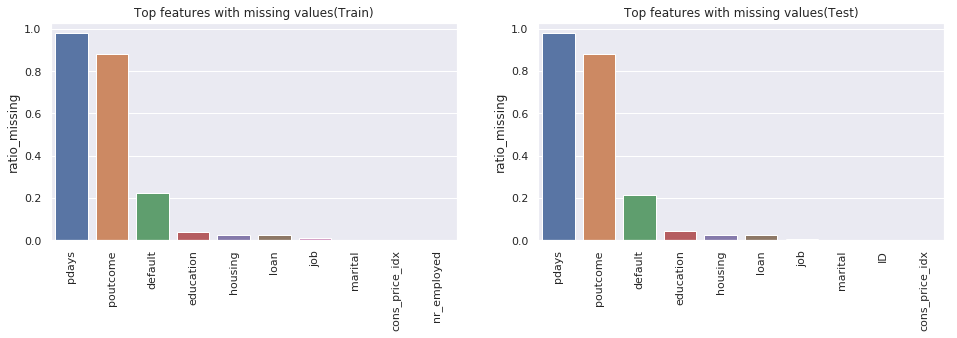

In [13]:
train_df_na_stat = df_missing_report(train_df).sort_values(by='ratio_missing',ascending=False).head(10)
test_df_na_stat = df_missing_report(test_df).sort_values(by='ratio_missing',ascending=False).head(10)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.barplot(x=train_df_na_stat.index, y="ratio_missing", data=train_df_na_stat.head(10), ax=ax[0]);
ax[0].set_xticklabels(labels=train_df_na_stat.index,rotation=90);
ax[0].set_title("Top features with missing values(Train)");

sns.barplot(x=test_df_na_stat.index, y="ratio_missing", data=test_df_na_stat.head(10),ax=ax[1]);
ax[1].set_xticklabels(labels=test_df_na_stat.index,rotation=90);
ax[1].set_title("Top features with missing values(Test)");

Features 'pdays' and 'poutcome' both have rate of missing values more than 80%. They can be removed from the datasets

In [14]:
columns_to_drop = ['pdays','poutcome']

train_df.drop(columns_to_drop,axis=1,inplace=True)
test_df.drop(columns_to_drop,axis=1,inplace=True)

num_cols = [ col for col in num_cols if col not in columns_to_drop ]
cat_cols = [ col for col in cat_cols if col not in columns_to_drop ]

### Missing Values Imputation

Imputing NA values in numeric columns

In [15]:
nan_cols_train = train_df.columns[train_df.isna().any()]
nan_cols_train = [col for col in nan_cols_train if col in num_cols] 

if len(nan_cols_train)>0:
    train_df[nan_cols_train] = df_impute(train_df[nan_cols_train],strategy='median') 
else:
    print('DataFrame Train has no missing values in numeric columns')
    
nan_cols_test = test_df.columns[test_df.isna().any()]
nan_cols_test = [col for col in nan_cols_test if col in num_cols] 

if len(nan_cols_test)>0:
    test_df[nan_cols_test] = df_impute(test_df[nan_cols_test],strategy='median') 
else:
    print('DataFrame Test has no missing values in numeric columns')

DataFrame Train has no missing values in numeric columns
DataFrame Test has no missing values in numeric columns


Imputing NA values in categorical columns

In [16]:
nan_cols_train = train_df.columns[train_df.isna().any()]
nan_cols_train = [col for col in nan_cols_train if col in cat_cols] 

if len(nan_cols_train)>0:
    train_df[nan_cols_train] = df_impute(train_df[nan_cols_train],strategy='value',value='nan') 
else:
    print('DataFrame Train has no missing values in categorical columns')
    
nan_cols_test = test_df.columns[test_df.isna().any()]
nan_cols_test = [col for col in nan_cols_test if col in cat_cols] 

if len(nan_cols_test)>0:
    test_df[nan_cols_test] = df_impute(test_df[nan_cols_test],strategy='value',value='nan') 
else:
    print('DataFrame Test has no missing values in categorical columns')

## Constant Values Exploring



Check if there are columns with constant values, if so they can be dropped

In [17]:
const_cols = train_df.columns[ train_df.nunique()==1 ]
print('Count of columns with constant value:',len(const_cols))

if len(const_cols)>0:
    train_df.drop(const_cols,axis=1,inplace=True)
    test_df.drop(const_cols,axis=1,inplace=True)

    num_cols = [ col for col in num_cols if col not in const_cols ]
    cat_cols = [ col for col in cat_cols if col not in const_cols ]

Count of columns with constant value: 0


## Some charts

Charts for first look on data destribution and other stats

### Numeric data

**Histograms**

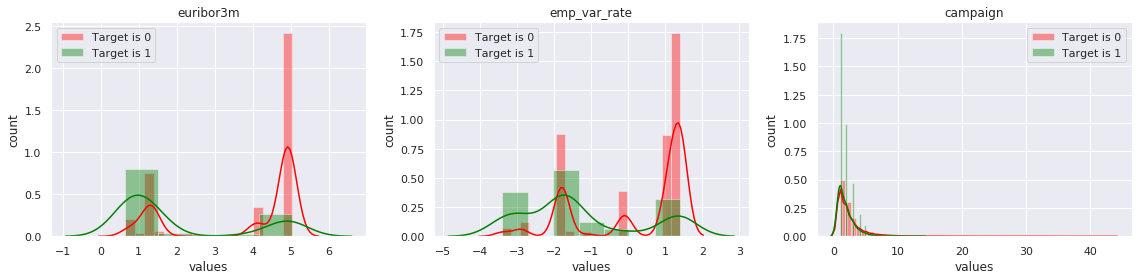

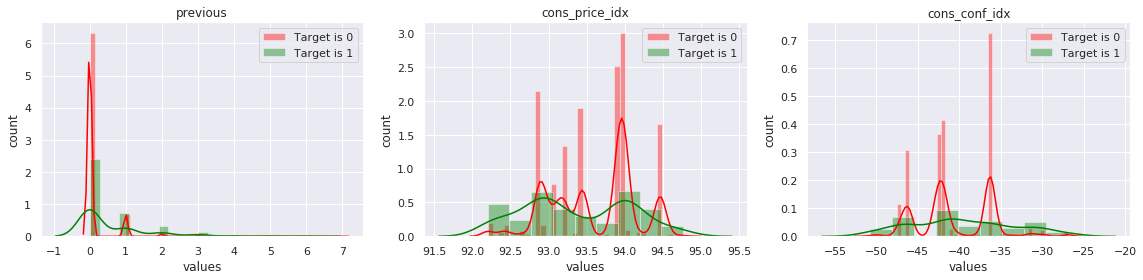

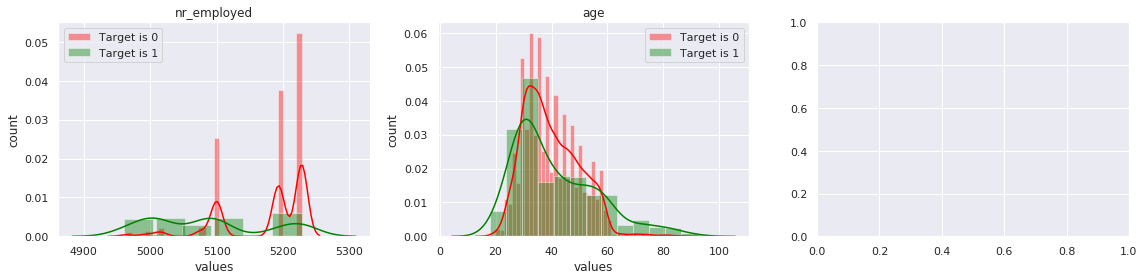

In [18]:
draw_plots(train_df,list(num_cols),xlabel = 'values',ylabel = 'count',\
           n_cols = 3,graph_type = 'hist',target_split=True)

Columns 'age' and 'campaign' have long tails and should be threated later

**Boxplots**

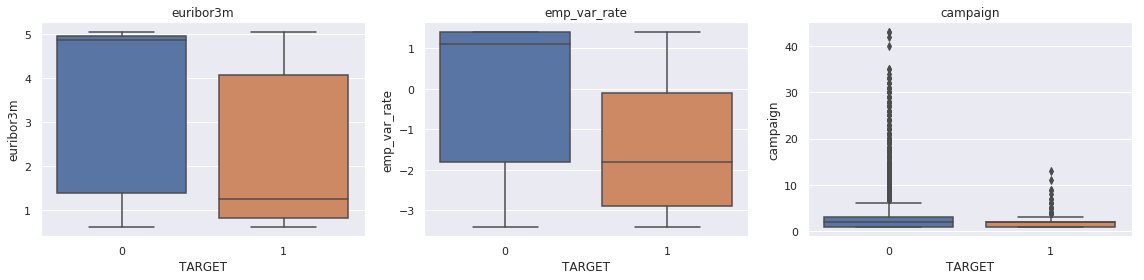

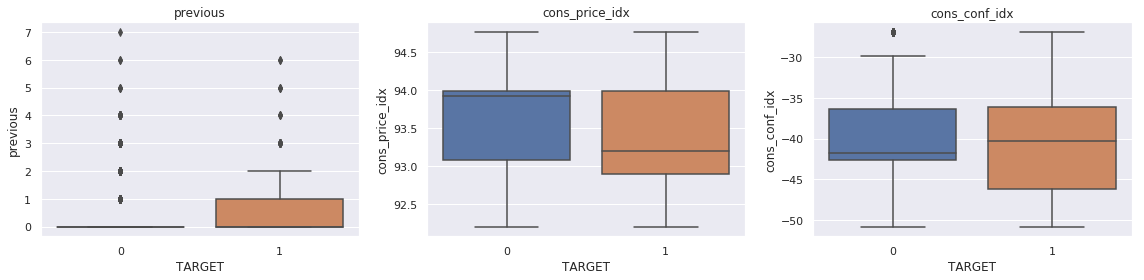

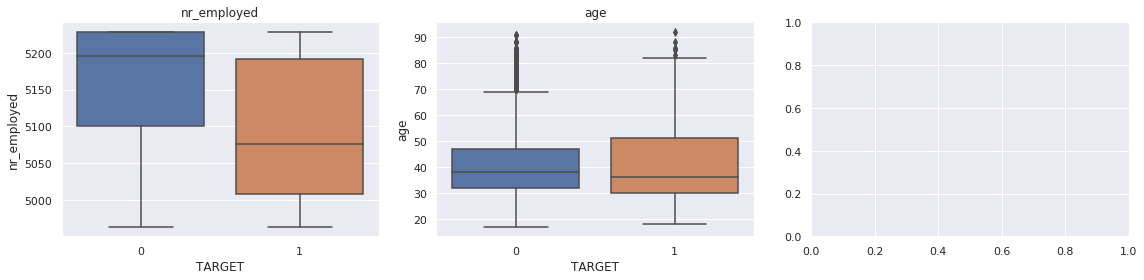

In [19]:
draw_plots(train_df,list(num_cols),xlabel = 'values',ylabel = 'count',\
           n_cols = 3,graph_type = 'boxplot',target_split=True)

**Unique values**  

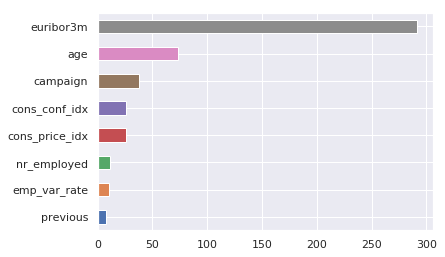

In [20]:
train_df[num_cols].nunique().sort_values().plot.barh();

For features 'euribor3m' and 'age' _Binning_ will be applied

### Categorical data

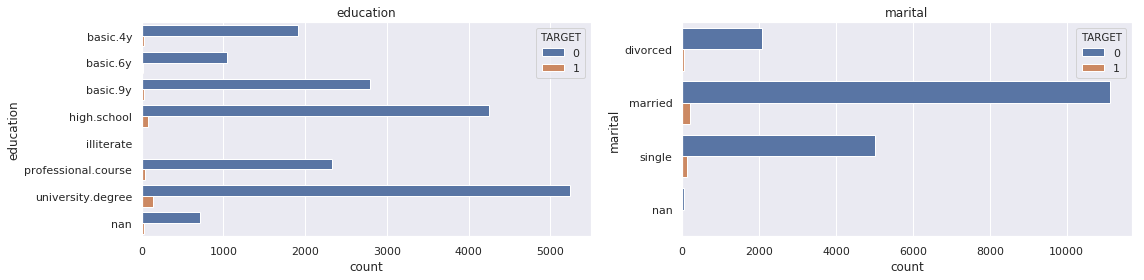

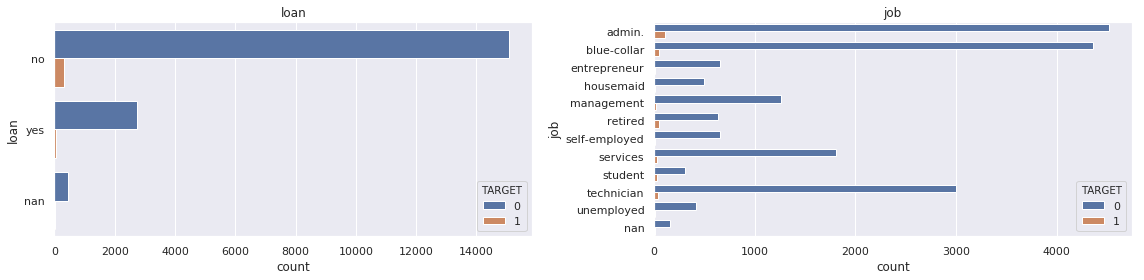

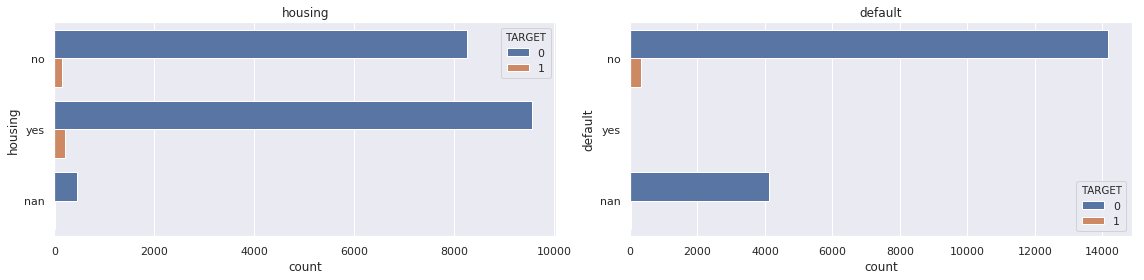

In [21]:
draw_plots(train_df,list(cat_cols),n_cols = 2,graph_type = 'countplot',target_split=True)

## Correlations

In [22]:
# Find correlations with the target and sort
corr = train_df[num_cols+cat_cols].corrwith(train_df['TARGET']).sort_values(ascending = False)

# Display correlations
print('Most Positive Correlations:\n', corr.head(5))
print('\nMost Negative Correlations:\n', corr.tail(5))

Most Positive Correlations:
 previous          0.144976
cons_conf_idx     0.031720
age               0.017579
campaign         -0.031162
cons_price_idx   -0.058280
dtype: float64

Most Negative Correlations:
 campaign         -0.031162
cons_price_idx   -0.058280
emp_var_rate     -0.145410
euribor3m        -0.152262
nr_employed      -0.189892
dtype: float64


**Nice correlation matrix:**

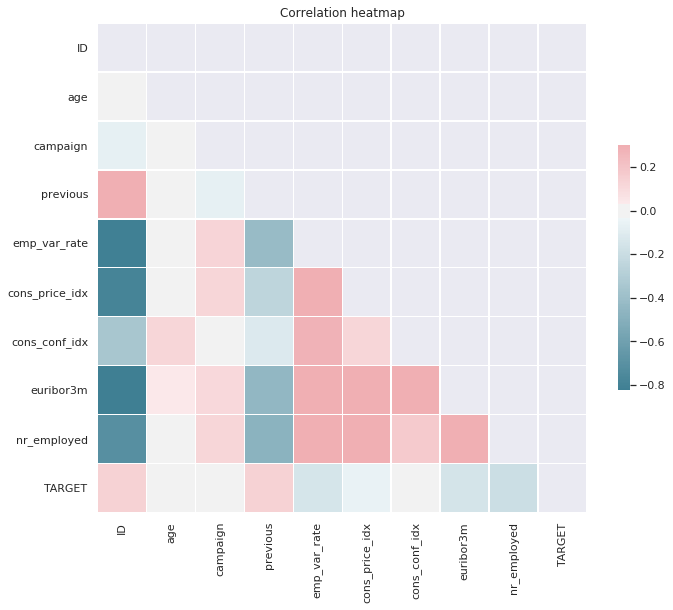

In [23]:
# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title('Correlation heatmap');

# Data transformation

## Union of train and test dataframes

Dataframes need to be concatenated for transformation purpose

In [24]:
train_idx = train_df.shape[0]
df_all = pd.concat([train_df, test_df], axis = 0, ignore_index = True)
print('Сombined shape: {}'.format(df_all.shape))

Сombined shape: (37682, 16)


## Features one by one

### age

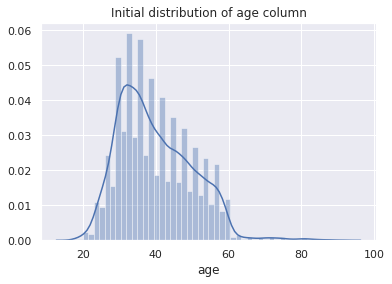

In [25]:
sns.distplot(df_all.iloc[:train_idx]['age']); # transformation will be made based on train distribution
plt.title('Initial distribution of age column');

**Outliers**  
Based on distribution above we will set :
 - 19 for all values of age less than 20
 - 61 for all values of age more than 60 

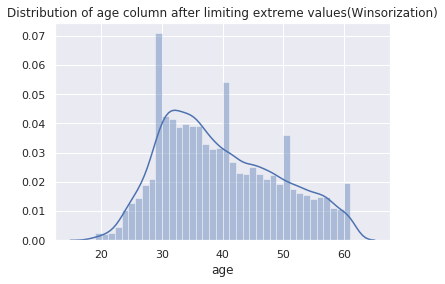

In [26]:
df_all['age'] = df_all['age'].mask(df_all['age'] < 20, 19)
df_all['age'] = df_all['age'].mask(df_all['age'] > 60, 61)
sns.distplot(df_all.iloc[:train_idx]['age']);
plt.title('Distribution of age column after limiting extreme values(Winsorization)');

**Binning**

In [27]:
quantilies = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.]

df_all['age_cats'] = pd.qcut(df_all['age'],quantilies).astype('str')

df_all['age_cats'].value_counts().sort_index()

(18.999, 29.0]    4984
(29.0, 32.0]      5057
(32.0, 38.0]      9210
(38.0, 47.0]      9549
(47.0, 54.0]      5247
(54.0, 61.0]      3635
Name: age_cats, dtype: int64

### euribor3m

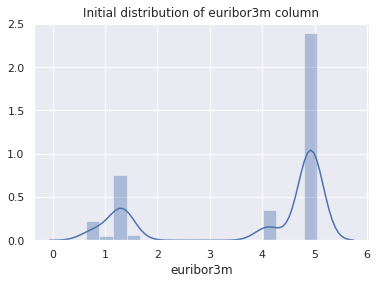

In [28]:
sns.distplot(df_all.iloc[:train_idx]['euribor3m']);
plt.title('Initial distribution of euribor3m column');

Distribution has not outliers so we will apply only **binning**

In [29]:
quantilies = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.]

df_all['euribor3m_cats'] = pd.qcut(df_all['euribor3m'],quantilies).astype('str')

df_all['euribor3m_cats'].value_counts().sort_index()

(0.633, 1.252]    3780
(1.252, 1.405]    6218
(1.405, 4.857]    9317
(4.857, 4.961]    8982
(4.961, 4.964]    6025
(4.964, 5.045]    3360
Name: euribor3m_cats, dtype: int64

### campaign

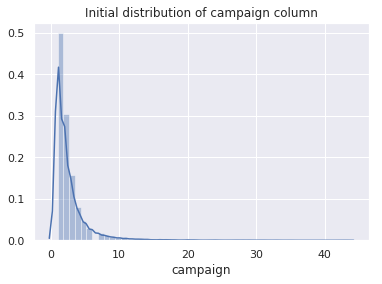

In [30]:
sns.distplot(df_all.iloc[:train_idx]['campaign']);
plt.title('Initial distribution of campaign column');

We see lognormal distibution with long tail. We will set to 11 all values which are more than 10

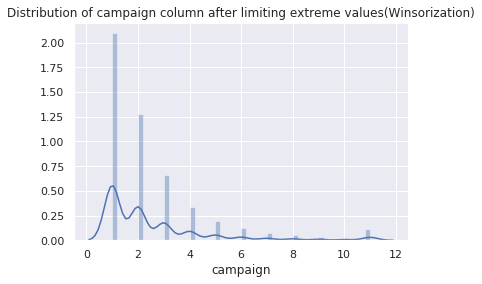

In [31]:
df_all['campaign'] = df_all['campaign'].mask(df_all['campaign'] > 10, 11)

sns.distplot(df_all.iloc[:train_idx]['campaign']);
plt.title('Distribution of campaign column after limiting extreme values(Winsorization)');

## Categories Encoding

In [32]:
_,cat_cols,num_cols = df_feats_summary(df_all,cols_to_exclude=['TARGET','ID'])
print('\nUnique values for categorical features:\n{}'.\
          format(df_all[cat_cols].nunique().sort_values(ascending=False)))

Columns summary (total 18) : 
        1. Categorical: 8
        2. Numerical: 8
        3. Excluded: 2

Unique values for categorical features:
job               12
education          8
euribor3m_cats     6
age_cats           6
marital            4
default            3
loan               3
housing            3
dtype: int64


**Applying One-Hot Encoding**

In [33]:
df_all = pd.get_dummies(data = df_all,columns = cat_cols, drop_first= True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37682 entries, 0 to 37681
Data columns (total 47 columns):
ID                               37682 non-null uint16
TARGET                           18647 non-null float64
age                              37682 non-null uint8
campaign                         37682 non-null uint8
cons_conf_idx                    37682 non-null float16
cons_price_idx                   37682 non-null float32
emp_var_rate                     37682 non-null float16
euribor3m                        37682 non-null float32
nr_employed                      37682 non-null float16
previous                         37682 non-null uint8
age_cats_(29.0, 32.0]            37682 non-null uint8
age_cats_(32.0, 38.0]            37682 non-null uint8
age_cats_(38.0, 47.0]            37682 non-null uint8
age_cats_(47.0, 54.0]            37682 non-null uint8
age_cats_(54.0, 61.0]            37682 non-null uint8
housing_yes                      37682 non-null uint8
housing_nan   

## Features scaling


In [34]:
df_all[num_cols] = preproc.StandardScaler().fit_transform(df_all[num_cols])

## Split dataframe back to train and test
After all data transformation we split train and test back

In [35]:
train_df = df_all[:train_idx].reset_index(drop=True)
test_df = df_all[train_idx:].reset_index(drop=True)
print('Train shape:{} Test shape{}:'.format(train_df.shape,test_df.shape))

Train shape:(18647, 47) Test shape(19035, 47):


In [36]:
train_df.head()

,ID,TARGET,age,campaign,cons_conf_idx,cons_price_idx,emp_var_rate,euribor3m,nr_employed,previous,...,"euribor3m_cats_(4.964, 5.045]",education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_nan,default_yes,default_nan
0,1,0.0,-0.291037,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,1,0,0,0,0,0,0
1,2,0.0,0.542366,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,1,0,0,0,0,0,0,1
2,3,0.0,2.000820,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,0,0,1,0,0,0,0
3,4,0.0,0.125664,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,0,0,0,0,1,0,1
4,5,0.0,-1.645316,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,0,0,1,0,0,0,0


In [37]:
test_df.head()

,ID,TARGET,age,campaign,cons_conf_idx,cons_price_idx,emp_var_rate,euribor3m,nr_employed,previous,...,"euribor3m_cats_(4.964, 5.045]",education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_nan,default_yes,default_nan
0,18648,NaN,1.688294,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,0,0,0,0,0,0,0
1,18649,NaN,1.792469,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,1,0,0,0,0,0,1
2,18650,NaN,0.021489,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,1,0,0,0,0,0,0,0,0
3,18651,NaN,1.688294,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,1,0,0,0,0,0,0
4,18652,NaN,-1.541140,-0.695912,0.93644,0.703651,0.593165,0.657811,0.268947,-0.327865,...,0,0,0,1,0,0,0,0,0,0


In [38]:
# features lists update
_,cat_cols,num_cols = df_feats_summary(train_df,cols_to_exclude=['TARGET','ID'])

# Drop ID columns in train and TARGET column in test
train_df.drop(columns=['ID'],axis=1,inplace=True)
test_df.drop(columns=['TARGET'],axis=1,inplace=True)

Columns summary (total 47) : 
        1. Categorical: 0
        2. Numerical: 45
        3. Excluded: 2


# Fixing imbalance dataset

To fix imbalaced data we will apply SMOTE oversampling  
https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html?highlight=smote

In [39]:
X_oversampled, y_oversampled = SMOTE(random_state=0).fit_resample(train_df[num_cols], train_df['TARGET'])
train_df_oversampled = pd.DataFrame(X_oversampled,columns=num_cols)
train_df_oversampled['TARGET'] = y_oversampled

# Train / holdout split

Stratified 80/20 train/holdout split

In [40]:
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state = 0)
X = train_df_oversampled[num_cols]
y = train_df_oversampled['TARGET']
for train_index, ho_index in sss.split(X, y):
    X_train, X_ho = X.iloc[train_index], X.iloc[ho_index]
    y_train, y_ho = y[train_index], y[ho_index]
print('Train shape:{} HoldOut shape:{}'.format(X_train.shape,X_ho.shape))

Train shape:(29238, 45) HoldOut shape:(7310, 45)


# Modeling

For modeling we will use four most popular classication algorithmes with default params: 
- Logistic Regression
- Random Forest
- K-nearest neighbors 
- LightGBM
    
    
Choice of **F1 score** as performance measurement was based on the paper __[Facing Imbalanced Data--Recommendations for the Use of Performance Metrics](https://ieeexplore.ieee.org/document/6681438?arnumber=6681438&tag=1)__
   
   
   
   
Strategy of choosing a classifier is following:
 - Split initial train dataframe on X_train and X_ho(holdout)
 - Make crossvalidation(5 stratified folds) on X train for every classifier
 - Measure mean crossvalidation score
 - See standart deviation on crossvalidation
 - Fit classifier on full X_train and measure score on X_ho
 - Choose classifier with highest score and minimum difference(more robust) between cv5_mean score and holdout score 

In [41]:
classifiers = {('Logistic Regression', LogisticRegression(random_state = 0, n_jobs=-1)), 
               ('Random Forest', RandomForestClassifier(random_state = 0, n_jobs=-1)),
               ('KNN', KNeighborsClassifier(n_neighbors = 5, n_jobs=-1)),
               ('LGBM', LGBMClassifier(random_state = 0, n_jobs=-1))
              }

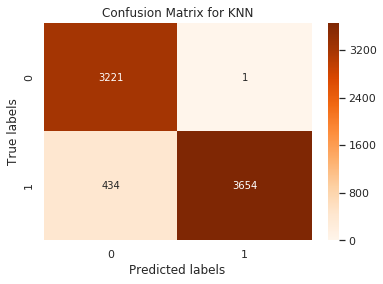

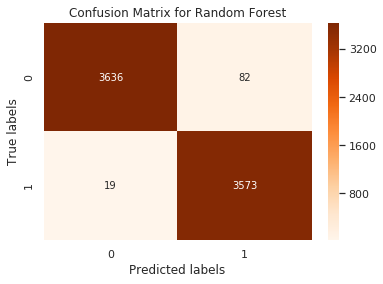

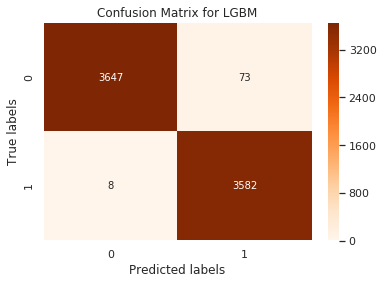

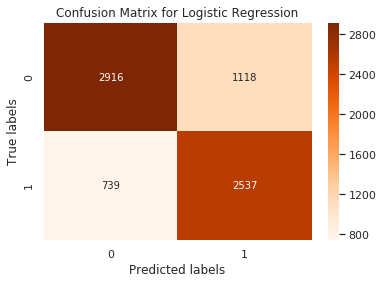

CPU times: user 47.4 s, sys: 7.32 s, total: 54.7 s
Wall time: 15.3 s


In [42]:
%%time
df_models = pd.DataFrame(columns = ['Model',\
                                    'Fold 1 Score',\
                                    'Fold 2 Score',\
                                    'Fold 3 Score',\
                                    'Fold 4 Score',\
                                    'Fold 5 Score',\
                                    'CV 5 Mean Score',
                                    'CV 5 std',
                                    'HoldOut Score',
                                    'abs(HoldOut Score - CV5 Mean Score)'])
for clf_name,clf in classifiers:
    # Crossvalidation
    scores_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring = 'f1_micro')
    scores_df = pd.DataFrame([scores_cv],columns = ['Fold 1 Score',\
                                                    'Fold 2 Score',\
                                                    'Fold 3 Score',\
                                                    'Fold 4 Score',\
                                                    'Fold 5 Score'])
    scores_df.insert(loc=0, column='Model', value=clf_name)
    scores_df['CV 5 Mean Score'] = scores_cv.mean()
    scores_df['CV 5 std'] = scores_cv.std()

    # Fit on full train
    clf.fit(X_train,y_train) 

    # Predict on holdout
    pred_X_ho = clf.predict(X_ho)
    score_ho = f1_score(pred_X_ho,y_ho)
    scores_df['HoldOut Score'] = score_ho
    scores_df['abs(HoldOut Score - CV5 Mean Score)'] = abs(score_ho - scores_cv.mean())
    
    #Draw a confusion matrix 
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(pred_X_ho,y_ho), annot=True, ax = ax,fmt='g',cmap="Oranges"); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix for {}'.format(clf_name)); 
    plt.show()

    
    df_models.loc[-1] = scores_df.iloc[0]
    df_models.index = df_models.index + 1
    df_models = df_models.sort_index() 

In [43]:
df_models.sort_values('abs(HoldOut Score - CV5 Mean Score)')

,Model,Fold 1 Score,Fold 2 Score,Fold 3 Score,Fold 4 Score,Fold 5 Score,CV 5 Mean Score,CV 5 std,HoldOut Score,abs(HoldOut Score - CV5 Mean Score)
1,LGBM,0.989398,0.986491,0.988030,0.989398,0.990421,0.988748,0.001360,0.988820,0.000072
2,Random Forest,0.986662,0.984781,0.984781,0.987517,0.988710,0.986490,0.001540,0.986063,0.000427
3,KNN,0.928523,0.931943,0.936218,0.931259,0.930209,0.931630,0.002567,0.943820,0.012190
0,Logistic Regression,0.747264,0.751710,0.750171,0.736491,0.749059,0.746939,0.005422,0.732073,0.014866


LightGBM is better on CV5_mean_score, Holdout score and difference between CV and holdout. So we will choose LightGBM as our final classifier

# Prediction for test

In [44]:
clf = LGBMClassifier(random_state=0)
clf.fit(X,y);

prediction_test = test_df[['ID']]
test_df.drop(columns = ['ID'], axis = 1, inplace = True)
prediction_test['prob'] = clf.predict_proba(test_df)[:, 1]
prediction_test['pred'] = clf.predict(test_df)

prediction_test.to_csv('predictions.csv',index = False);